# Data visualization and Preprocessing

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Step 2: Visualize the distribution of labels
def plot_label_distribution(dataloader):
    label_counts = [0] * 10
    for _, labels in dataloader:
        for label in labels:
            label_counts[label.item()] += 1

    labels = [str(i) for i in range(10)]
    plt.bar(labels, label_counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Labels in MNIST Dataset')
    plt.show()

plot_label_distribution(trainloader)

# Step 3: Visualize samples from each class
def visualize_samples(dataloader, num_samples=5):
    class_samples = {i: [] for i in range(10)}

    for images, labels in dataloader:
        for image, label in zip(images, labels):
            if len(class_samples[label.item()]) < num_samples:
                class_samples[label.item()].append(image)

    fig, axes = plt.subplots(10, num_samples, figsize=(12, 12))

    for i in range(10):
        for j in range(num_samples):
            axes[i, j].imshow(class_samples[i][j].squeeze(), cmap='gray')
            axes[i, j].axis('off')

    plt.suptitle('Samples from Each Class')
    plt.show()

visualize_samples(trainloader)

# Step 4: Check for class imbalance
label_counts = [0] * 10
for _, labels in trainloader:
    for label in labels:
        label_counts[label.item()] += 1

print("Class Imbalance:")
for i, count in enumerate(label_counts):
    print(f"Class {i}: {count} samples")


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


# Partitioning the dataset into train, validation, and test sets

In [12]:
# Step 5: Partition the dataset into train, validation, and test sets
train_size = int(0.8 * len(trainset))
val_size = int(0.1 * len(trainset))
test_size = len(trainset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(trainset, [train_size, val_size, test_size])
gen = torch.Generator().manual_seed(42)
# Create train and validation data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Convolutional Neural Network in Python from Scratch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report

class CNN(nn.Module):
    def __init__(self, dropout_size=0.25, strides=2, kernel_size=3,pool_size = 2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pool_size,stride=strides)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.var1 = int((28-pool_size)/strides)+1
        self.dim = int((self.var1-pool_size)/strides)+1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_size)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(-1,64*self.dim*self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model with custom dropout, strides, and kernel_size
model = CNN(dropout_size=0.25, strides=2, kernel_size=3)

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_predicted , all_actual = [] , []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_predicted.extend(predicted.tolist())
                all_actual.extend(labels.tolist())

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc , all_actual , all_predicted



Epoch 1/5, Train Loss: 0.2072, Train Acc: 93.81%, Val Loss: 0.0496, Val Acc: 98.48%
Epoch 2/5, Train Loss: 0.0623, Train Acc: 98.10%, Val Loss: 0.0436, Val Acc: 98.50%
Epoch 3/5, Train Loss: 0.0450, Train Acc: 98.59%, Val Loss: 0.0358, Val Acc: 98.93%
Epoch 4/5, Train Loss: 0.0368, Train Acc: 98.81%, Val Loss: 0.0292, Val Acc: 99.12%
Epoch 5/5, Train Loss: 0.0286, Train Acc: 99.10%, Val Loss: 0.0318, Val Acc: 99.10%
99.1
Confusion Matrix
[[588   0   0   0   1   0   1   0   2   0]
 [  0 720   1   0   0   1   0   1   0   0]
 [  1   1 621   0   1   0   0   1   1   0]
 [  0   0   2 607   0   1   0   0   1   0]
 [  0   1   0   0 578   0   0   0   1   0]
 [  0   0   0   1   0 524   3   0   0   0]
 [  1   0   1   0   2   0 598   0   0   0]
 [  0   1   1   0   1   1   0 575   0   1]
 [  0   0   0   2   0   0   1   0 556   2]
 [  1   0   0   1  10   2   0   2   2 579]]

Class 0: Accuracy = 99.32%
Class 1: Accuracy = 99.59%
Class 2: Accuracy = 99.20%
Class 3: Accuracy = 99.35%
Class 4: Accuracy 

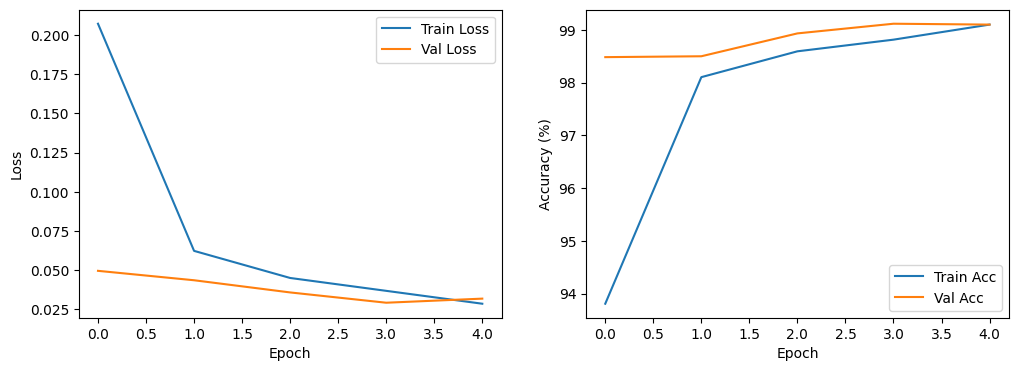

In [14]:
# Train the model
train_losses, val_losses, train_acc, val_acc , all_actual , all_predicted = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
print(val_acc[-1])
print("Confusion Matrix")
print(confusion_matrix(all_actual,all_predicted))
print()

classwise_accuracy = []

for class_label in range(10):
    correct = sum(1 for a, p in zip(all_actual, all_predicted) if a == class_label and p == class_label)
    total = all_actual.count(class_label)
    accuracy = correct / total if total > 0 else 0.0
    classwise_accuracy.append(accuracy)
    print(f'Class {class_label}: Accuracy = {accuracy * 100:.2f}%')

class_names = [str(i) for i in range(10)]
classification_rep = classification_report(all_actual, all_predicted, target_names=class_names)
print(classification_rep)
    
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Feature Maps

In [ ]:
# Function to display feature maps
sample_loader = iter(val_loader)
sample_image, sample_label = next(sample_loader)

def display_feature_maps(class_id):
    # Get the activations from the first convolutional layer (conv1)
    activation = model.conv1(sample_image)
    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[0].permute(1, 2, 0).numpy())
    plt.title(f"Sample Image(Class:{sample_label})")
    # Display the feature maps
    plt.subplot(1, 2, 2)
    plt.imshow(activation[0,class_id].detach().numpy(), cmap='viridis')
    plt.title(f'Feature Maps for Class {class_id}')
    plt.show()

class_id = 0  # Change this to the desired class index
# Call the function to display the feature maps for the specified class
display_feature_maps(class_id)

# Hyperparameter Tuning

In [ ]:
import wandb
wandb.init(project="Convolution-Neural-Networks")
sweep_config = {
    "method": "grid",
    "name": "Convolution-Neural-Networks",
    "metric": {"goal": "maximize", "name": "val_accuracy"},
    "parameters": {
        "learning_rate": {"values": [0.001,0.01]},
        "batch_size": {"values": [64,128]},
        "kernel_size": {"values": [3,5]},
        "strides": {"values": [1,2]},
        "num_epochs": {"values": [3,5]},
        "dropout_rate": {"values": [0.5,0.7]},
    },
}
criterion = nn.CrossEntropyLoss()
sweep_id = wandb.sweep(sweep_config, project="Convolution-Neural-Networks")
def train():
    wandb.init(project="Convolution-Neural-Networks")
    config = wandb.config
    learning_rate = config.learning_rate
    batch_size = config.batch_size
    dropout_rate = config.dropout_rate
    kernel_size = config.kernel_size
    strides = config.strides
    num_epochs = config.num_epochs
    print(learning_rate,batch_size,dropout_rate,kernel_size,strides,num_epochs)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,generator=gen)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False,generator=gen)
    model = CNN(dropout_size=dropout_rate, strides=strides, kernel_size=kernel_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses, val_losses, train_acc, val_acc , all_actual , all_predictions = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
    wandb.log({"Trainset Loss":train_losses[-1],"Trainset Accuracy":train_acc[-1],"Validation set Loss":val_losses[-1],"val_accuracy":val_acc[-1]})

# Run the sweep
wandb.agent(sweep_id, function=train)
wandb.finish()

# CNN without Dropout Layer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report

class CNNWD(nn.Module):
    def __init__(self, strides=2, kernel_size=3,pool_size=2):
        super(CNNWD, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pool_size,stride=strides)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.var1 = int((28-pool_size)/strides)+1
        self.dim = int((self.var1-pool_size)/strides)+1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model with strides, and kernel_size
model = CNNWD(strides=2, kernel_size=3)

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_predicted , all_actual = [] , []

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_predicted.extend(predicted.tolist())
                all_actual.extend(labels.tolist())

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc



In [ ]:
# Train the model
train_losses, val_losses, train_acc, val_acc, all_actual , all_predicted = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)
print(val_acc[-1])
print("Confusion Matrix")
print(confusion_matrix(all_actual,all_predicted))
print()

classwise_accuracy = []

for class_label in range(10):
    correct = sum(1 for a, p in zip(all_actual, all_predicted) if a == class_label and p == class_label)
    total = all_actual.count(class_label)
    accuracy = correct / total if total > 0 else 0.0
    classwise_accuracy.append(accuracy)
    print(f'Class {class_label}: Accuracy = {accuracy * 100:.2f}%')

class_names = [str(i) for i in range(10)]
classification_rep = classification_report(all_actual, all_predicted, target_names=class_names)
print(classification_rep)
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

```
4.4 Model Evaluation and Analysis [10 marks]
```

# Evaluation on Test Dataset

Epoch 1/5, Train Loss: 0.2027, Train Acc: 93.69%, Val Loss: 0.0561, Val Acc: 98.22%
Epoch 2/5, Train Loss: 0.0661, Train Acc: 98.01%, Val Loss: 0.0380, Val Acc: 98.75%
Epoch 3/5, Train Loss: 0.0475, Train Acc: 98.56%, Val Loss: 0.0328, Val Acc: 98.87%
Epoch 4/5, Train Loss: 0.0392, Train Acc: 98.77%, Val Loss: 0.0311, Val Acc: 99.07%
Epoch 5/5, Train Loss: 0.0312, Train Acc: 99.00%, Val Loss: 0.0330, Val Acc: 98.98%
98.98333333333333


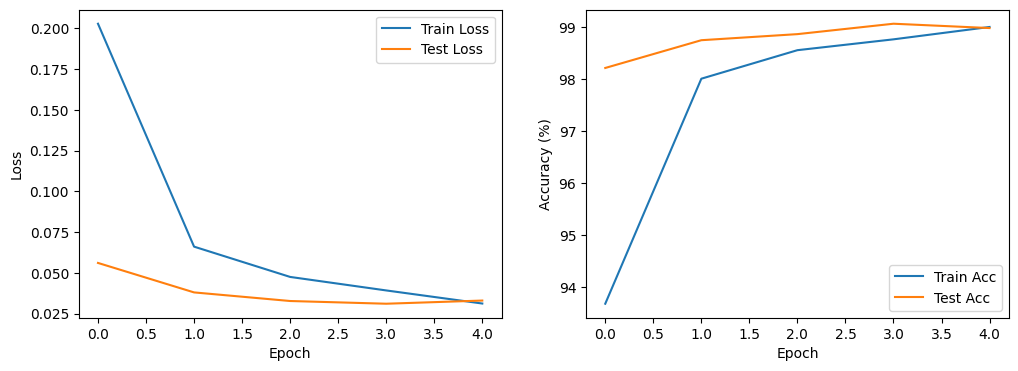

In [4]:
# Initialize the model with custom dropout, strides, and kernel_size
model = CNN(dropout_size=0.25, strides=2, kernel_size=3)
# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the model
train_losses, test_losses, train_acc, test_acc , all_actual , all_predicted  = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5)
print(test_acc[-1])

print("Confusion Matrix")
print(confusion_matrix(all_actual,all_predicted))
print()

classwise_accuracy = []

for class_label in range(10):
    correct = sum(1 for a, p in zip(all_actual, all_predicted) if a == class_label and p == class_label)
    total = all_actual.count(class_label)
    accuracy = correct / total if total > 0 else 0.0
    classwise_accuracy.append(accuracy)
    print(f'Class {class_label}: Accuracy = {accuracy * 100:.2f}%')

class_names = [str(i) for i in range(10)]
classification_rep = classification_report(all_actual, all_predicted, target_names=class_names)
print(classification_rep)

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(test_acc, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

```
4.5 Train on Noisy Dataset [10 marks]
```

# Dataset with Noise

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io
from sklearn.metrics import classification_report , accuracy_score
class CNN(nn.Module):
    def __init__(self, dropout_size=0.25, strides=2, kernel_size=3,pool_size = 2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pool_size,stride=strides)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size,padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.var1 = int((28-pool_size)/strides)+1
        self.dim = int((self.var1-pool_size)/strides)+1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_size)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = x.view(-1,1,28,28)
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(-1,64*self.dim*self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    


mat = scipy.io.loadmat('mnist-with-awgn.mat')
# Load the noisy MNIST dataset from .mat file
X_train = mat['train_x']
y_train = mat['train_y']
X_test = mat['test_x']
y_test = mat['test_y']

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# Conversion to Tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
print(X_train.shape)
# Creating Loaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

torch.Size([48000, 784])


Epoch 1/2, Train Loss: 0.5757, Train Acc: 85.90%, Val Loss: 0.1885, Val Acc: 94.21%
Epoch 2/2, Train Loss: 0.2206, Train Acc: 93.12%, Val Loss: 0.1601, Val Acc: 95.04%
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1206
           1       0.98      0.97      0.97      1334
           2       0.93      0.96      0.95      1198
           3       0.93      0.95      0.94      1228
           4       0.97      0.95      0.96      1193
           5       0.95      0.94      0.95      1058
           6       0.95      0.99      0.97      1200
           7       0.95      0.96      0.95      1277
           8       0.96      0.89      0.92      1176
           9       0.92      0.92      0.92      1130

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



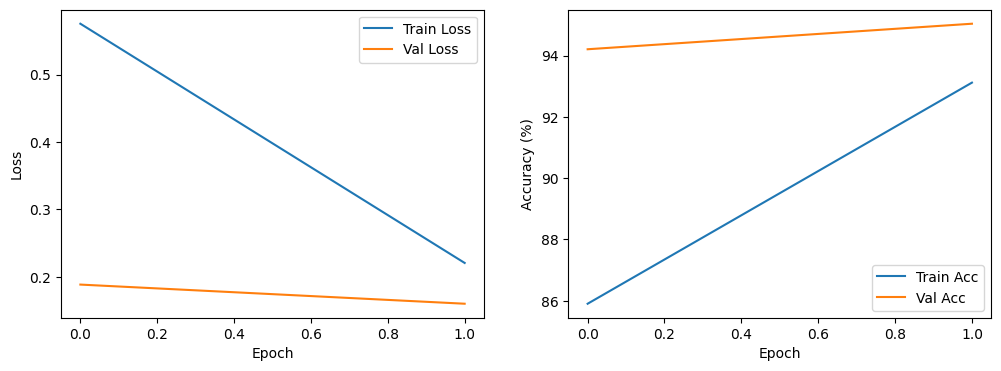

In [3]:
# Initialize and train your model
model = CNN(dropout_size=0.25, strides=2, kernel_size=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2  # You can adjust the number of epochs
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        train_accuracy = 0.0

        for i, data in enumerate(train_loader,0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_classes = torch.argmax(labels,dim=1)
            train_accuracy += accuracy_score(correct_classes.tolist(),predicted.tolist())*len(labels)

        train_accuracy /= total_train
        train_accuracy *= 100
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        total_val = 0
        val_accuracy = 0.0
        all_actual = []
        all_predictions = []
        with torch.no_grad():
            for i, data in enumerate(val_loader,0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_classes = torch.argmax(labels,dim=1)
                val_accuracy+= accuracy_score(correct_classes.tolist(),predicted.tolist())*len(labels)
                all_predictions.extend(predicted.tolist())
                all_actual.extend(correct_classes.tolist())

            val_accuracy /= total_val
            val_accuracy *= 100
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc , all_actual , all_predictions
train_losses, val_losses, train_acc, val_acc , all_actual , all_predictions = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
# Print the classification report
print(classification_report(all_actual, all_predictions))
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


Epoch 1/2, Train Loss: 0.1787, Train Acc: 94.43%, Val Loss: 0.1188, Val Acc: 96.29%
Epoch 2/2, Train Loss: 0.1630, Train Acc: 94.83%, Val Loss: 0.1190, Val Acc: 96.38%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.98      0.94      0.96      1032
           3       0.97      0.96      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.96      0.96       892
           6       0.97      0.97      0.97       958
           7       0.93      0.98      0.95      1028
           8       0.94      0.95      0.95       974
           9       0.96      0.92      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



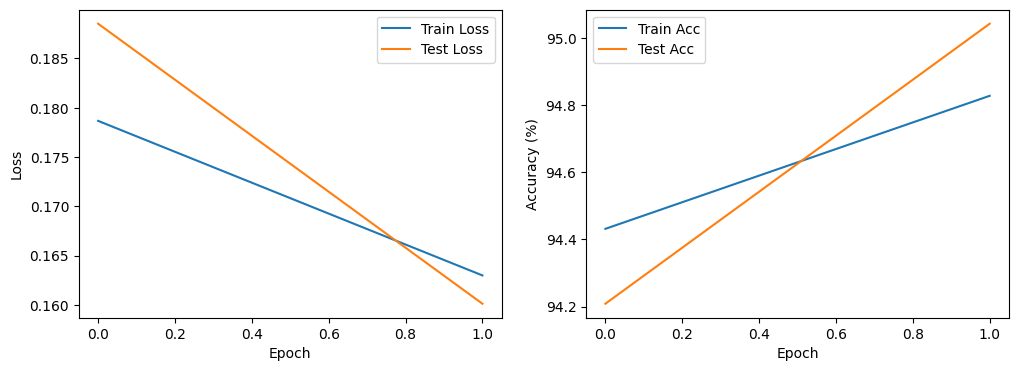

In [4]:
train_losses, test_losses, train_acc, test_acc , all_actual , all_predictions = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)
# Print the classification report
print(classification_report(all_actual, all_predictions))
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Auto Encoder Class in Python from Scratch

In [7]:
class Autoencoder(nn.Module):
    def __init__(self,input_size,hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),  
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, input_size),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
input_size = 784
hidden_size = 128
AutoEncoder = Autoencoder(input_size=input_size,hidden_size=hidden_size)
AE_criterion = nn.MSELoss()
AE_optimizer = optim.Adam(AutoEncoder.parameters(), lr=0.001)

epochs = 10
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for data in train_loader:
        AE_optimizer.zero_grad()
        inputs = data 
        outputs = AutoEncoder(inputs.float())
        loss = AE_criterion(outputs.float(), inputs.float())  # Compare the reconstruction with the input
        loss.backward()
        AE_optimizer.step()

clean_train_data = AutoEncoder(torch.Tensor(X_train)).detach()
clean_validation_data = AutoEncoder(torch.Tensor(X_val)).detach()
clean_test_data = AutoEncoder(torch.Tensor(X_test)).detach()

X_train = torch.Tensor(clean_train_data)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(clean_validation_data)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(clean_test_data)
y_test = torch.Tensor(y_test)
print(X_train.shape)
# Creating Loaders
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)

torch.Size([48000, 784])


Epoch 1/2, Train Loss: 0.1715, Train Acc: 94.61%, Val Loss: 0.1219, Val Acc: 96.23%
Epoch 2/2, Train Loss: 0.1446, Train Acc: 95.48%, Val Loss: 0.1324, Val Acc: 95.86%
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1206
           1       0.99      0.98      0.98      1334
           2       0.96      0.96      0.96      1198
           3       0.90      0.98      0.94      1228
           4       0.98      0.96      0.97      1193
           5       0.92      0.97      0.94      1058
           6       0.97      0.97      0.97      1200
           7       0.97      0.96      0.96      1277
           8       0.97      0.89      0.93      1176
           9       0.93      0.94      0.94      1130

    accuracy                           0.96     12000
   macro avg       0.96      0.96      0.96     12000
weighted avg       0.96      0.96      0.96     12000



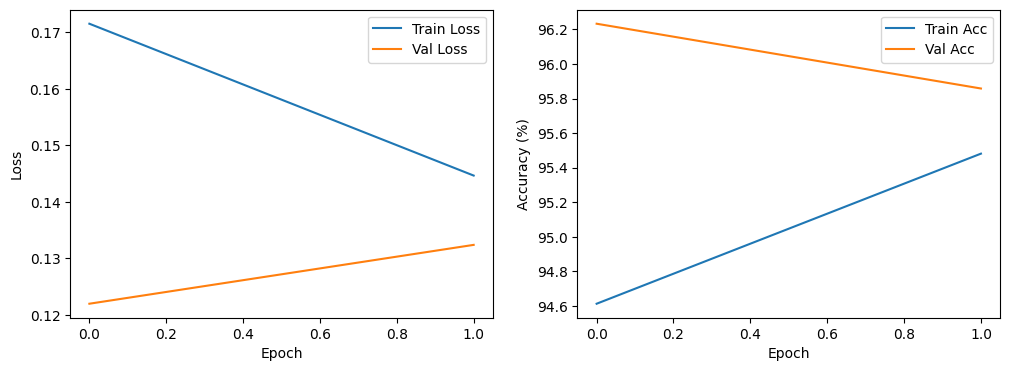

In [9]:
train_losses, val_losses, train_acc, val_acc , all_actual , all_predictions = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
# Print the classification report
print(classification_report(all_actual, all_predictions))
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Epoch 1/2, Train Loss: 0.1334, Train Acc: 95.78%, Val Loss: 0.1122, Val Acc: 96.69%
Epoch 2/2, Train Loss: 0.1254, Train Acc: 96.04%, Val Loss: 0.1190, Val Acc: 96.56%
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.97      0.96      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.99      0.97      0.98       892
           6       0.99      0.94      0.96       958
           7       0.92      0.98      0.95      1028
           8       0.97      0.95      0.96       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



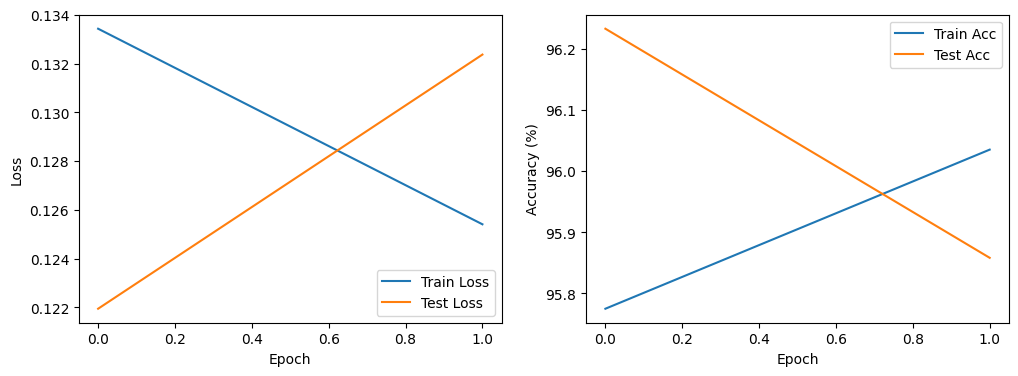

In [10]:
train_losses, test_losses, train_acc, test_acc , all_actual , all_predictions = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)
# Print the classification report
print(classification_report(all_actual, all_predictions))
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()